In [194]:
"""
The CNN (Convolutional neural network) Long Short-Term Memory Network or CNN LSTM for short is an LSTM architecture specifically designed for 
sequence prediction problems with spatial inputs, like images or videos.
"""
import glob
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import tensorflow.keras as keras
from tensorflow.keras import models, callbacks
from tensorflow.keras.layers import InputLayer, Input, Dense, Flatten, Conv2D, MaxPooling2D, Reshape, LSTM, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


tf.config.run_functions_eagerly(True)

In [195]:
# Definisci il modello CNN
def create_cnn():
    # Crea un modello sequenziale. Questo è un tipo di modello che consente di aggiungere strati uno alla volta in un ordine specifico.
    model = models.Sequential()

    # 0. Strato di input
    # Questo strato accetta immagini di dimensione 128x128 con 3 canali di colore (RGB) e un batch size di 1.
    model.add(InputLayer(shape=(1, 128, 128, 3)))
    
    # 1. Strato convoluzionale con regolarizzazione L2 e normalizzazione del batch
    # Questo strato ha 64 filtri, ciascuno di dimensione 3x3, e utilizza la funzione di attivazione ReLU.
    """
    64 è il numero di filtri che la convoluzione userà. Ogni filtro estrae una sorta di caratteristica dall'input.

    (3, 3) è la dimensione di ciascuno di questi 64 filtri. In questo caso, ogni filtro è una griglia 3x3.

    activation='relu' specifica che la funzione di attivazione ReLU (Rectified Linear Unit) dovrebbe essere usata dopo l'applicazione dei filtri. 
        La funzione ReLU trasforma tutti i valori negativi in 0, introducendo la non linearità nel modello, 
        che è essenziale per l'apprendimento di modelli complessi.
    """
    layer = Conv2D(64, (3, 3), activation='relu')
    # Aggiunge lo strato al modello, rendendolo distribuito nel tempo.
    model.add(TimeDistributed(layer))
    
    # 2. Strato di MaxPooling
    # Questo strato riduce la dimensione spaziale dell'output del precedente strato convoluzionale utilizzando una finestra di dimensione 2x2.
    layer = MaxPooling2D((2, 2))
    model.add(TimeDistributed(layer))
    
    # 3. Strato convoluzionale con regolarizzazione L2 e normalizzazione del batch
    # Questo strato ha 32 filtri, ciascuno di dimensione 3x3, e utilizza la funzione di attivazione ReLU.
    layer = Conv2D(32, (3, 3), activation='relu')
    model.add(TimeDistributed(layer))
    
    # 4. Strato di MaxPooling
    # Questo strato riduce ulteriormente la dimensione spaziale dell'output del precedente strato convoluzionale utilizzando una finestra di dimensione 2x2.
    layer = MaxPooling2D((2, 2))
    model.add(TimeDistributed(layer))
    
    # 5. Strato di appiattimento
    # Questo strato appiattisce l'output del precedente strato di MaxPooling in un vettore unidimensionale.
    layer = Flatten()
    model.add(TimeDistributed(layer))

    # 6. Strato LSTM con dropout
    # Questo strato LSTM ha 100 unità. L'LSTM è un tipo di rete neurale ricorrente che è efficace per l'apprendimento da sequenze di dati.
    model.add(LSTM(100))
    
    # 7. Strato denso
    # Questo strato denso ha 2 unità e utilizza la funzione di attivazione sigmoide. Questo è lo strato di output del modello.
    model.add(Dense(2, kernel_regularizer=regularizers.l2(0.0001), activation='sigmoid'))

    # Restituisce il modello creato
    return model

In [196]:
# Create the CNN model
model = create_cnn()

# Compila il modello, Adam è un algoritmo di ottimizzazione,
# loss per definire la cross-entropia binaria come funzione di perdita 
# metrics è una lista di metriche da valutare durante l'addestramento e il test.
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

print("Il riepilogo include il numero di strati nel modello, la forma dell'output di ciascuno strato e il numero totale di parametri nel modello.")
model.summary()

Il riepilogo include il numero di strati nel modello, la forma dell'output di ciascuno strato e il numero totale di parametri nel modello.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_15             │ (None, 1, 126, 126,    │         1,792 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 1, 63, 63, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 1, 61, 61, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 1, 30, 30, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 1, 28800)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │    11,560,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,580,858 (44.18 MB)

 Trainable params: 11,580,858 (44.18 MB)

 Non-trainable params: 0 (0.00 B)

In [197]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
CLASSES = ["COVID", "non-COVID"]
NUM_CLASSES = len(CLASSES)

In [240]:
def extract_df_from_images_path(IMAGE_PATH):
    image_files = []
    image_classes = []
    
    # Ottieni una lista di tutte le immagini e le loro classi
    for root, dirs, files in os.walk(IMAGE_PATH):
        for file in files:
            if file.endswith((".jpg", ".png")):
                image_files.append(os.path.join(root, file))
                image_classes.append(os.path.basename(root))  # La classe è il nome della directory

    # Inizializza una lista per i dati delle immagini
    image_data = []

    # Processa ogni immagine
    for i, (image_file, image_class) in enumerate(zip(image_files, image_classes)):
        print(f"Processing image {i+1}/{len(image_files)}: {image_file}")

        # Apri l'immagine e stampa le sue dimensioni originali
        image = Image.open(image_file)
        print(f"Original size: {image.size}")

        # Ridimensiona l'immagine e stampa le sue nuove dimensioni
        """
        image.thumbnail((128, 128))
        print(f"Resized size: {image.size}")

        # Crea una nuova immagine con dimensioni fisse e incolla l'immagine ridimensionata al centro
        new_size = (128, 128)
        new_im = Image.new("RGB", new_size)   # Colore di sfondo bianco
        new_im.paste(
            image, 
            (
                (new_size[0]-image.size[0])//2,
                (new_size[1]-image.size[1])//2
            )
        )
        
        print(f"Final resized size: {new_im.size}")  # Stampa le dimensioni finali dell'immagine
        
        
        # Converti l'immagine in un array numpy, appiattiscilo e aggiungilo alla lista dei dati delle immagini
        image_array = np.array(new_im)
        """
        
        image_array = np.array(image.resize(IMAGE_SIZE))
        
        
        
        image_data.append(image_array)

    # Crea un DataFrame con i dati delle immagini e le classi
    df = pd.DataFrame(
        {   
            'image': image_data, 
            'label': [1 if x == 'COVID' else 0 for x in image_classes] 
        }
        )
        
    # Restituisci il DataFrame finale
    return df

In [241]:
train_df = extract_df_from_images_path("./Datasets")

Processing image 1/2481: ./Datasets\COVID\Covid (1).png
Original size: (256, 202)
Processing image 2/2481: ./Datasets\COVID\Covid (10).png
Original size: (370, 307)
Processing image 3/2481: ./Datasets\COVID\Covid (100).png
Original size: (348, 256)
Processing image 4/2481: ./Datasets\COVID\Covid (1000).png
Original size: (331, 315)
Processing image 5/2481: ./Datasets\COVID\Covid (1001).png
Original size: (333, 308)
Processing image 6/2481: ./Datasets\COVID\Covid (1002).png
Original size: (341, 296)
Processing image 7/2481: ./Datasets\COVID\Covid (1003).png
Original size: (327, 307)
Processing image 8/2481: ./Datasets\COVID\Covid (1004).png
Original size: (374, 296)
Processing image 9/2481: ./Datasets\COVID\Covid (1005).png
Original size: (322, 316)
Processing image 10/2481: ./Datasets\COVID\Covid (1006).png
Original size: (328, 317)
Processing image 11/2481: ./Datasets\COVID\Covid (1007).png
Original size: (347, 318)
Processing image 12/2481: ./Datasets\COVID\Covid (1008).png
Original 

In [242]:
from sklearn.model_selection import train_test_split


# Converti i vettori di immagini in un array numpy
X = np.stack(train_df['image'].values)

# Converti le etichette in una rappresentazione one-hot
y = to_categorical(train_df['label'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

ValueError: all input arrays must have the same shape

In [226]:
print("X_train shape:", len(X_train))
print("y_train shape:", len(y_train))
print("X_val shape:", len(X_val))
print("y_val shape:", len(y_val))
print("X_test shape:", len(X_test))
print("y_test shape:", len(y_test))

dict_train = {
    'index': [0,1],
    'values': [y_train[y_train==np.array([1,0])].shape[0], y_train[y_train==np.array([0,1])].shape[0]]
}

dict_test = {
    'index': [0,1],
    'values': [y_test[y_test==np.array([1,0])].shape[0], y_test[y_test==np.array([0,1])].shape[0]]
}

X_train shape: 1488
y_train shape: 1488
X_val shape: 496
y_val shape: 496
X_test shape: 497
y_test shape: 497


{'index': [0, 1], 'values': [1482, 1494]}
{'index': [0, 1], 'values': [502, 492]}


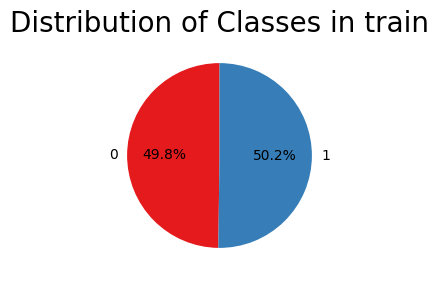

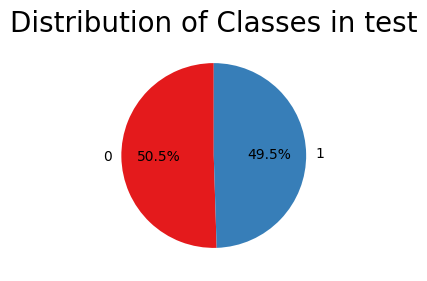

In [229]:
plt.figure(figsize=(3, 3))
print(dict_train)
print(dict_test)
tr_labels = dict_train['index']
tr_sizes = dict_train['values']
plt.pie(tr_sizes, labels=tr_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set1'))
plt.title('Distribution of Classes in train', fontsize=20)
plt.show()

plt.figure(figsize=(3, 3))
ts_labels = dict_test['index']
ts_sizes = dict_test['values']
plt.pie(ts_sizes, labels=ts_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set1'))
plt.title('Distribution of Classes in test', fontsize=20)
plt.show()

In [230]:
for label, size in zip(tr_labels, tr_sizes):
    print(f"Label: {label}, Size: {size}")

Label: 0, Size: 1482
Label: 1, Size: 1494


In [231]:
for label, size in zip(ts_labels, ts_sizes):
    print(f"Label: {label}, Size: {size}")

Label: 0, Size: 502
Label: 1, Size: 492


In [232]:
work_dr = ImageDataGenerator(rescale=1./255)

In [179]:
# train_data = None
# train_labels = None
# steps = len(train_data_gen)
# for i, (data, labels) in enumerate(train_data_gen):
#     print(i)
#     if i == 0:
#         train_data = data
#         train_labels = labels
#     elif i < steps:
#         train_data = np.concatenate((train_data, data), axis=0)
#         train_labels = np.concatenate((train_labels, labels), axis=0)
#     else:
#         break

# print(train_data.shape, train_labels.shape)

In [236]:
# X_train, X_test, y_train, y_test = train_test_split(train_data,train_labels, test_size=0.2, random_state=42,shuffle=True,stratify=train_labels)
if X_train.ndim == 4:
    X_train = np.expand_dims(X_train, axis=1)
if X_test.ndim == 4:
    X_test = np.expand_dims(X_test, axis=1)
if X_val.ndim == 4:
    X_val = np.expand_dims(X_val, axis=1)
    
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_val shape is ' , y_val.shape)


X_train shape is  (1488, 1, 128, 128, 3)
X_test shape is  (497, 1, 128, 128, 3)
y_train shape is  (1488, 2)
y_test shape is  (497, 2)
X_val shape is  (496, 1, 128, 128, 3)
y_val shape is  (496, 2)


In [238]:
# Define callbacks

callbacks_list = [
   #callbacks.EarlyStopping(monitor='accuracy', patience=2),  # Stop training if accuracy doesn't improve after 3 epochs
    callbacks.ModelCheckpoint(filepath='./Models/CNN-LSTM-MIGLIORE-binary_crossentropy-val.keras', monitor='loss'),  # Save the best model based on val_accuracy
]

# Fit the model
keras.config.disable_traceback_filtering()


history = model.fit(X_train, y_train, batch_size=16, epochs=25, callbacks=callbacks_list, validation_data=(X_val, y_val))

Epoch 1/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.4950 - loss: 0.9858 - precision_2: 0.4950 - recall_2: 0.4950 - val_accuracy: 0.4778 - val_loss: 0.9663 - val_precision_2: 0.4778 - val_recall_2: 0.4778
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.4900 - loss: 0.9570 - precision_2: 0.4900 - recall_2: 0.4900 - val_accuracy: 0.4778 - val_loss: 0.9388 - val_precision_2: 0.4778 - val_recall_2: 0.4778
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.5069 - loss: 0.9283 - precision_2: 0.5069 - recall_2: 0.5069 - val_accuracy: 0.4778 - val_loss: 0.9144 - val_precision_2: 0.4778 - val_recall_2: 0.4778
Epoch 4/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.4820 - loss: 0.9083 - precision_2: 0.4820 - recall_2: 0.4820 - val_accuracy: 0.4778 - val_loss: 0.8922 - val_precision_2: 0.4778 - val_recall_2: 0.4778
Epoch 5/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.5032 - loss: 0.8852 - precision_2: 0.5032 - recall_2: 0.5032 - val_

KeyboardInterrupt: 

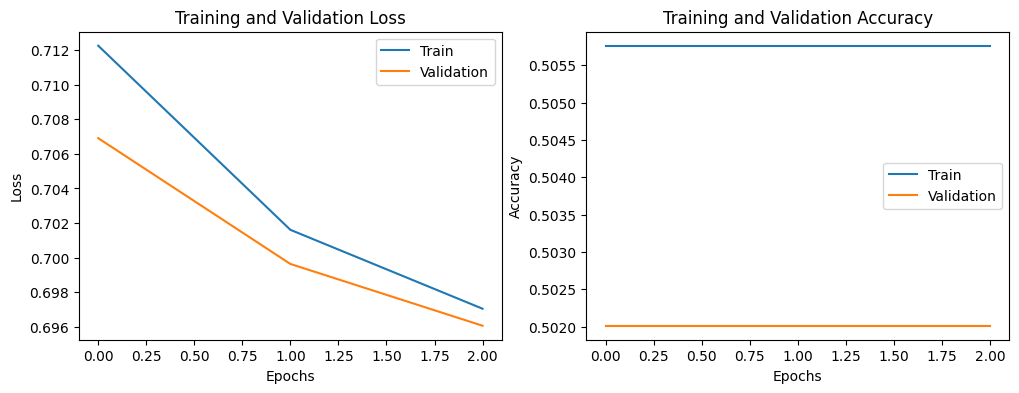

In [188]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

156/156 ━━━━━━━━━━━━━━━━━━━━ 46s 292ms/step


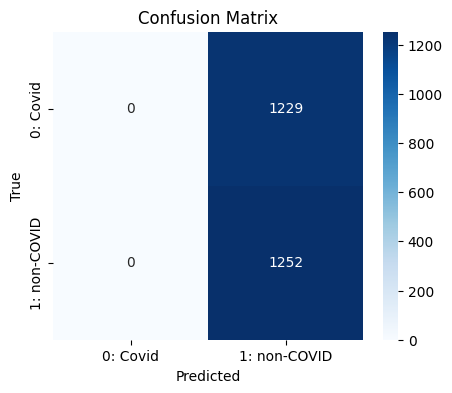

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1229
           1       0.50      1.00      0.67      1252

    accuracy                           0.50      2481
   macro avg       0.25      0.50      0.34      2481
weighted avg       0.25      0.50      0.34      2481



In [189]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

y_pred = model.predict(X_test, batch_size=16)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# y_pred = model.predict(X_test, batch_size=16)
# y_true = y_test.reshape(-1, 1)
# y_pred_classes = np.round(y_pred).astype(int)
# y_true_classes = y_true

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0: Covid', '1: non-COVID'],
            yticklabels=['0: Covid', '1: non-COVID'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, zero_division=0.0))

In [190]:
score, acc, p, r = model.evaluate(X_test, y_test, batch_size=16)
print('Test Loss =', score)
print('Test Accuracy =', acc)

c:\Users\nikba\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


156/156 ━━━━━━━━━━━━━━━━━━━━ 53s 340ms/step - accuracy: 0.8439 - loss: 0.6410 - precision_1: 0.8439 - recall_1: 0.8439
Test Loss = 0.6956352591514587
Test Accuracy = 0.504635214805603
